# Regressions on Gcn4 data
I'm worried that ADHunter is essentially just picking up composition, so I want to run a few regressions on nt / dinucleotide content and compare the Spearman correlations. 

In [ ]:
%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNOneHotSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import logomaker
import os
os.chdir("../adhunter")



In [3]:
fn = "data/OrthologTilingDFwActivities_20220131.csv"
# df = pd.read_csv(fn, index_col=0)
# df = df.loc[df.Activity != 0.0]
# # average over duplicates
# df = df.groupby("Seq").mean().reset_index()

df = pd.read_csv(fn)
df = df.loc[df.Activity != 0.0]
df = df.iloc[:, 1:]
df = df.loc[df.loc[:, ['Seq', 'Activity']].drop_duplicates().index]
df = df.sort_values(by=["SpeciesNames", "NativeLocation"]).reset_index(drop=True)

seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)

# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)
# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
# aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
# i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
# X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

In [12]:
# df.Seq.str.count("AA"), seqs[0]
import re
from itertools import product
np.char.count(seqs[0], "AA"), seqs[0]
count_kmers = lambda seq, pair: seq.count(pair)
dipeptides = ["".join(j) for j in [i for i in product(alphabet, repeat=2)]]
# dipeptides = ["".join(j) for j in [i for i in combinations(alphabet, 2)]]
get_input_2mers = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])
get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
# Additional functions to double count where applicable: eg AAAA -> 4 AA instead of 2 AA
count_kmers_all = lambda seq, pair: len(re.findall(f'(?=({pair}))', seq))
get_input_2mers_all = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])

# X_2mers = np.vstack(df["Seq"].apply(get_input_2mers).values)
X_2mers = np.vstack(df["Seq"].apply(get_input_2mers_all).values)
X_aa = np.vstack(df["Seq"].apply(get_input_single).values)
X_combined = np.hstack([X_2mers, X_aa])
# # Optional to do 3mers
# tripeptides = ["".join(j) for j in [i for i in product(alphabet, repeat=3)]]
# get_input_3mers = lambda seq: np.array([count_kmers(seq, tri) for tri in tripeptides])
# X_3mers = np.vstack(df["Seq"].apply(get_input_3mers).values)

In [13]:
from sklearn.model_selection import train_test_split
X_2mer_train, X_2mer_test, y_2mer_train, y_2mer_test = train_test_split(X_2mers, y_cont, stratify=y_bin, train_size=.8)
X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split(X_aa, y_cont, stratify=y_bin, train_size=.8)
X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_combined, y_cont, stratify=y_bin, train_size=.8)


In [ ]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_2mer_train, y_2mer_train)
print(regr.score(X_2mer_test, y_2mer_test)) 

regr_single = LinearRegression()
regr_single.fit(X_aa_train, y_aa_train)
print(regr_single.score(X_aa_test, y_aa_test)) 

regr_comb = LinearRegression()
regr_comb.fit(X_comb_train, y_comb_train)
print(regr_comb.score(X_comb_test, y_comb_test)) 

0.49240512968203176
0.3822913764646435
0.4838944348746831


/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_2322/4167840346.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


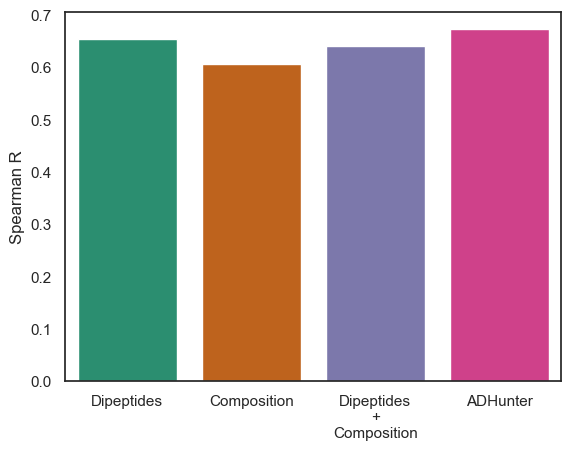

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_2322/4167840346.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot({


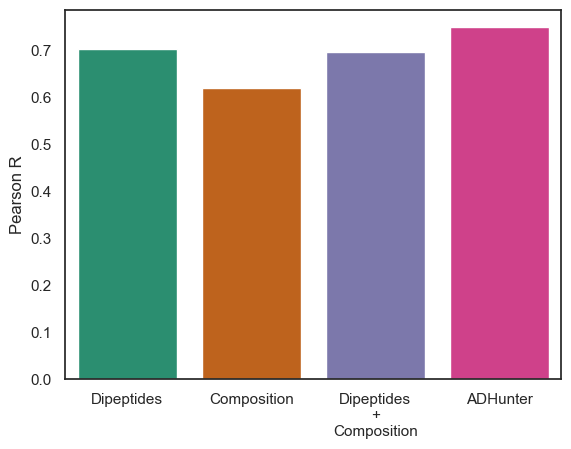

In [ ]:
r_2mer, _ = spearmanr(regr.predict(X_2mer_test), y_2mer_test)
r_aa, _ = spearmanr(regr_single.predict(X_aa_test), y_aa_test)
r_comb, _ = spearmanr(regr_comb.predict(X_comb_test), y_comb_test)

sns.barplot({
    "Dipeptides": r_2mer, 
    "Composition": r_aa, 
    "Dipeptides\n+\nComposition": r_comb,
    "ADHunter": .673, # NOTE: This was the spearman from initial training of ADHunter
    }, errorbar=None, palette='Dark2')
plt.ylabel("Spearman R")
plt.show()

r_2mer, _ = pearsonr(regr.predict(X_2mer_test).flatten(), y_2mer_test.flatten())
r_aa, _ = pearsonr(regr_single.predict(X_aa_test).flatten(), y_aa_test.flatten())
r_comb, _ = pearsonr(regr_comb.predict(X_comb_test).flatten(), y_comb_test.flatten())

sns.barplot({
    "Dipeptides": r_2mer, 
    "Composition": r_aa, 
    "Dipeptides\n+\nComposition": r_comb,
    "ADHunter": .748, # NOTE: This came from me retraining the model since I didn't save train/test splits...
    }, errorbar=None, palette='Dark2')
plt.ylabel("Pearson R")
plt.show()
# pearsonr(regr_comb.predict(X_comb_test), y_comb_test)

In [143]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

def spearman_scorer(y_true, y_pred):
    rho, _ = spearmanr(y_true, y_pred)
    return rho

# Create a scorer object
spearman_metric = make_scorer(spearman_scorer)
scores = cross_val_score(regr, X_2mer_test, y_2mer_test, cv=5, scoring=spearman_metric)
scores

array([0.58099969, 0.58210874, 0.57539924, 0.5951296 , 0.62774649])

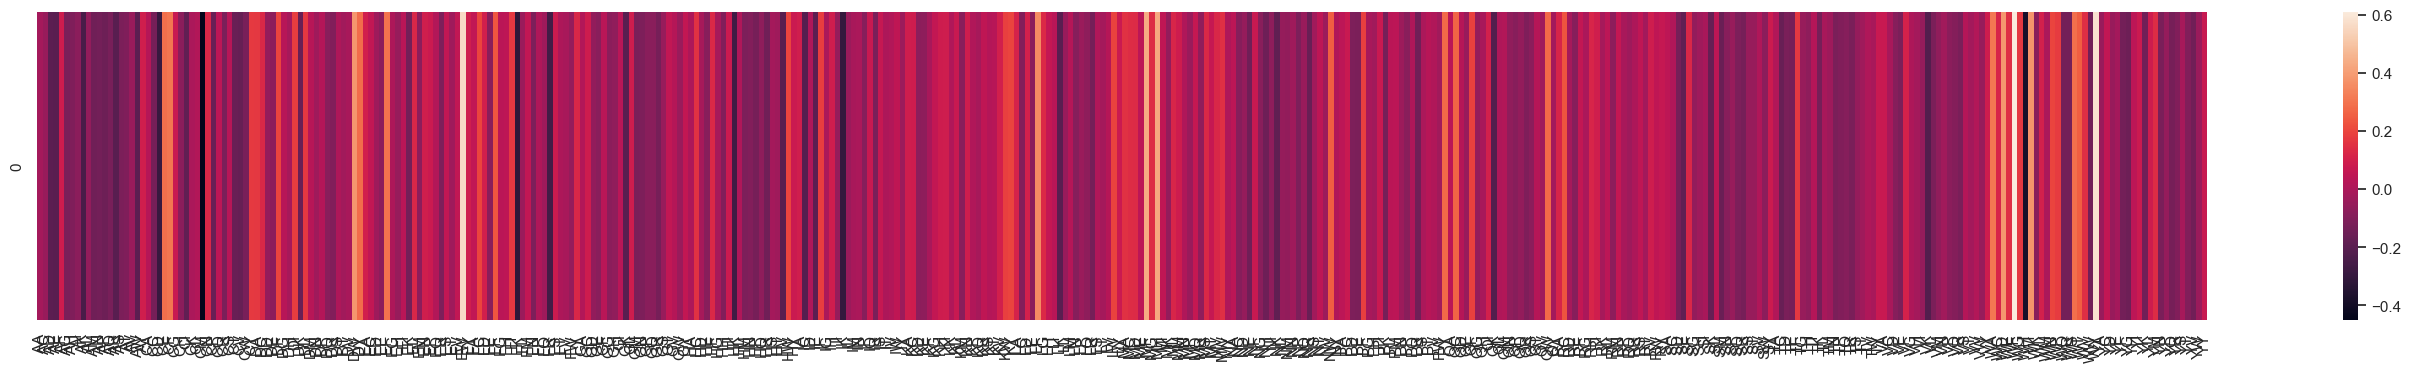

In [123]:
fig, ax = plt.subplots(figsize=(35,4))
sns.heatmap(regr.coef_, xticklabels=True, ax=ax)
ax.set_xticklabels(dipeptides)
plt.show()

In [22]:
from statsmodels.regression.linear_model import OLS

model = OLS(y_2mer_train, X_2mer_train).fit()
print(model.rsquared)
print(model.rsquared_adj)

0.5029883775490974
0.4890401105891339


### Compare to ADHunter

In [ ]:
# Load in ADHunter
def encode(seq):
    assert len(seq) == 40, "Sequence must be 40 AA!"
    return torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64)

kernel_size = 5
dilation = 3 
hidden = 64
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

model = ActCNNOneHotSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))
model.eval()

# Store ADHunter predictions in the df
X_gene = torch.stack(list(df["Seq"].apply(encode).values)).squeeze()
# It's useful and quick to store ADHunter predictions in df:
with torch.no_grad():
    predicted_activity = model(X_gene).detach().numpy()
    # Need to unscale the predicted activity values
    activities_measured = df["Activity"].values.reshape(-1, 1)
    # scaler = preprocessing.StandardScaler().fit(activities_measured)
    # predicted_activity = scaler.inverse_transform(
    #     predicted_activity.reshape(-1, 1)
    #     ).flatten()
    df["Predicted Activity"] = predicted_activity
df_ad = df[df["Activity"] >= 80_000]
df

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


,SpeciesNames,NativeLocation,NormLocation,Seq,Activity,Predicted Activity
0,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,20,-115,MPTNDLNSAISMFEMNVNTPGAGAAAAAAPCNPSVGAYHM,40288.321578,-0.025787
1,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,25,-110,LNSAISMFEMNVNTPGAGAAAAAAPCNPSVGAYHMGVTPA,83054.688641,0.150322
2,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,30,-105,SMFEMNVNTPGAGAAAAAAPCNPSVGAYHMGVTPAEQHEA,49277.350646,-0.165960
3,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,40,-95,GAGAAAAAAPCNPSVGAYHMGVTPAEQHEALQSSASTSSS,16941.985045,-0.655540
4,Aace_AGO11762.1_SaccharomycetaceaeAshbyaAceri,45,-90,AAAAPCNPSVGAYHMGVTPAEQHEALQSSASTSSSDSSTL,14317.482226,-0.609236
...,...,...,...,...,...,...
18312,Zyro_ZYRO0D09174g,150,104,KLGVVSYNRKNRNAPLTPVLCESDDPVAMKRARNTEAARR,13787.243695,-0.330622
18313,Zyro_ZYRO0D09174g,155,109,SYNRKNRNAPLTPVLCESDDPVAMKRARNTEAARRSRARK,10209.754767,-0.531528
18314,Zyro_ZYRO0D09174g,175,129,PVAMKRARNTEAARRSRARKLERMSQLEERVEELLAKNEE,11115.682418,-0.579051
18315,Zyro_ZYRO0D09174g,180,134,RARNTEAARRSRARKLERMSQLEERVEELLAKNEELEKRN,12723.738589,-0.642136


In [ ]:
df[["Activity", "Predicted Activity"]].corr(method="pearson")

,Activity,Predicted Activity
Activity,1.00000,0.82253
Predicted Activity,0.82253,1.00000


### Calculate scores for some of the sequences ADHunter performs oddly on

In [ ]:
n_random = 1000
random_aromatics = ["".join(np.random.choice(list("WYF"), 40)) for _ in range(n_random)] + ["".join(["W" for _ in range(40)])]
encoded_random_aromatics = torch.stack([encode(i) for i in random_aromatics]).squeeze()
scores_random_aromatics = model(encoded_random_aromatics).detach().numpy()

# Spike aromatic clusters into miscellaneous sequences
def spike_in(n_res, choices=["W", "Y", "F"], background=["A"]):
    if type(choices) == str:
        choices = [choices]
    if type(background) == str:
        background = [background]
    seqs = []
    for i in range(40-n_res):
        # seqs.append(
        #     "".join(["A" for _ in range(i)]) + \
        #     "".join(np.random.choice(choices, n_res)) + \
        #     "".join(["A" for _ in range(40 - n_res - i)])
        # )
        seqs.append(
            "".join(np.random.choice(background, i)) + \
            "".join(np.random.choice(choices, n_res)) + \
            "".join(np.random.choice(background, 40 - n_res - i))
        )
    return seqs

phi_clusters = (
    spike_in(10, background=list(alphabet)) + \
    spike_in(5, background=list(alphabet)) + \
    spike_in(10, background=["A", "D", "E"]) + \
    spike_in(5, background=["A", "D", "E"]) + \
    spike_in(10) + \
    spike_in(5)
    )
encoded_phi_clusters = torch.stack([encode(i) for i in phi_clusters]).squeeze()
scores_phi_clusters = model(encoded_phi_clusters).detach().numpy().flatten()

In [ ]:
# Get inputs of the above for the regressions
def linreg_inputs(li):
    X_2mers = np.vstack(pd.Series(li).apply(get_input_2mers_all).values)
    X_aa = np.vstack(pd.Series(li).apply(get_input_single).values)
    X_combined = np.hstack([X_2mers, X_aa])
    return X_2mers, X_aa, X_combined

def linreg_pred(li):
    inputs_2mers, inputs_aa, inputs_comb = linreg_inputs(li)
    return regr.predict(inputs_2mers).flatten(), regr_single.predict(inputs_aa).flatten(), regr_comb.predict(inputs_comb).flatten()

ad_2mers, ad_aa, ad_comb = linreg_pred(df_ad["Seq"])
aro_2mers, aro_aa, aro_comb = linreg_pred(random_aromatics)
clust_2mers, clust_aa, clust_comb = linreg_pred(phi_clusters)
# linreg_pred(random_aromatics)

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_2322/3351150356.py:6: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot({


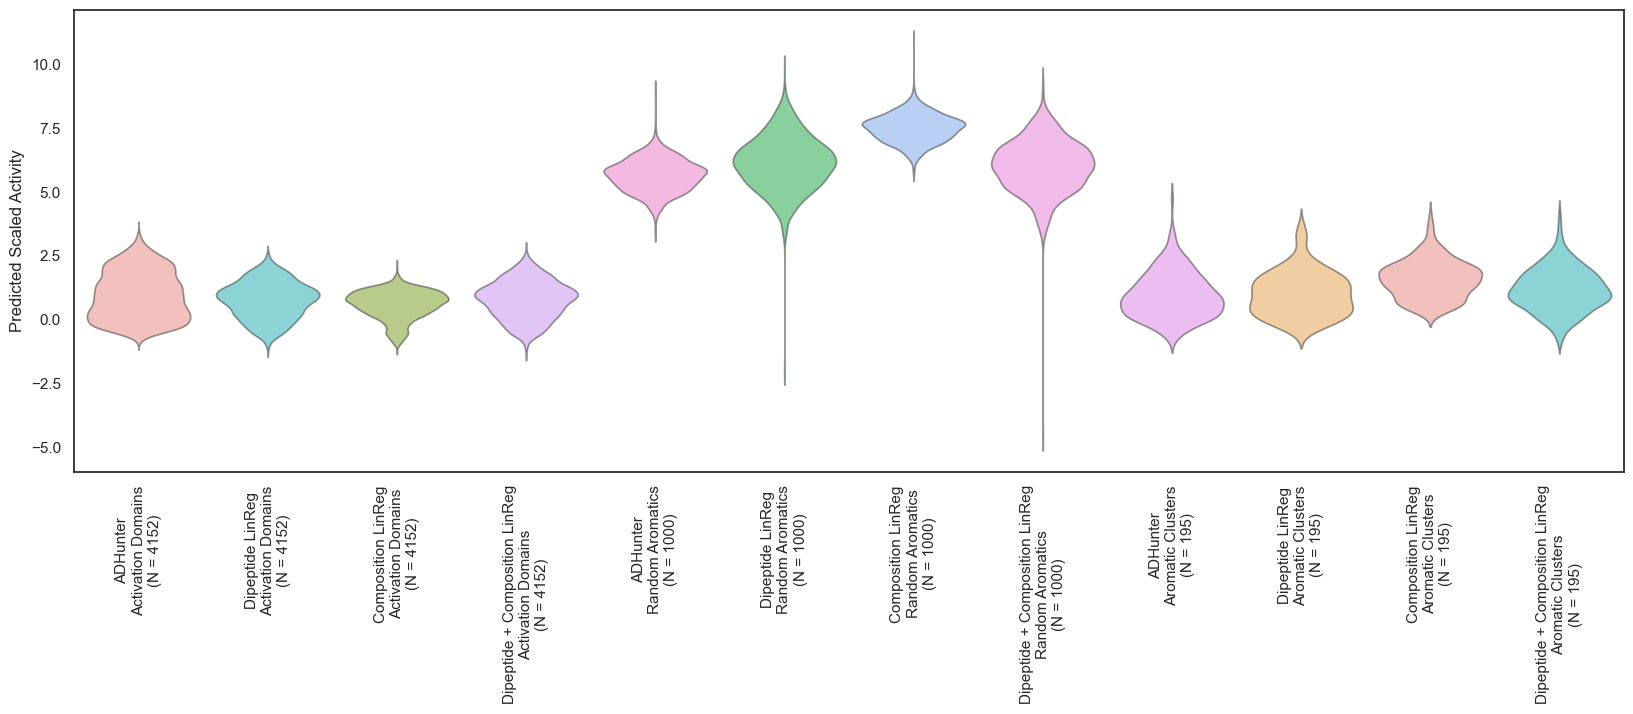

In [104]:
ggplot_colors = [
    "#F8766D", "#00BFC4", "#7CAE00", "#C77CFF", "#FF61CC", 
    "#00BA38", "#619CFF", "#F564E3", "#E76BF3", "#FF9E2C", 
]
fig, ax = plt.subplots(figsize=(20, 6))
sns.violinplot({
    f"ADHunter\nActivation Domains\n(N = {len(df_ad)})": df_ad["Predicted Activity"], 
    f"Dipeptide LinReg\nActivation Domains\n(N = {len(df_ad)})": ad_2mers,
    f"Composition LinReg\nActivation Domains\n(N = {len(df_ad)})": ad_aa,
    f"Dipeptide + Composition LinReg\nActivation Domains\n(N = {len(df_ad)})": ad_comb,

    f"ADHunter\nRandom Aromatics\n(N = {n_random})": scores_random_aromatics.flatten(),
    f"Dipeptide LinReg\nRandom Aromatics\n(N = {n_random})": aro_2mers,
    f"Composition LinReg\nRandom Aromatics\n(N = {n_random})": aro_aa,
    f"Dipeptide + Composition LinReg\nRandom Aromatics\n(N = {n_random})": aro_comb,

    f"ADHunter\nAromatic Clusters\n(N = {len(phi_clusters)})": scores_phi_clusters,
    f"Dipeptide LinReg\nAromatic Clusters\n(N = {len(phi_clusters)})": clust_2mers,
    f"Composition LinReg\nAromatic Clusters\n(N = {len(phi_clusters)})": clust_aa,
    f"Dipeptide + Composition LinReg\nAromatic Clusters\n(N = {len(phi_clusters)})": clust_comb,
    },
    inner=None, palette=ggplot_colors, alpha=.5,
    ax=ax,
    )
plt.xticks(rotation=90, ha='center')
plt.ylabel("Predicted Scaled Activity")
plt.show()

In [105]:
all_one = lambda aa: "".join([aa for _ in range(40)])
# for aa in alphabet:
#     print(f"All {aa}: {model(encode(all_one(aa))).item()}")
